In [255]:
from ect.tracking import (
    # DECTTransformer, 
    FECTCorrTransformer, 
    FFTTransformer,
    NaiveMatcher
)
from ect.helpers import SingleImageGenerator

from typing import Callable

import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import grey, magma, gist_heat
from matplotlib.axes import Axes

from ect import complex_to_hsv, Config

In [256]:
TEMPLATE_PATH = './_tracking_src/1_template.png'
SCALED_PATH = './_tracking_src/1_scaled_50.png'
ROTATED_PATH = './_tracking_src/1_rotated_60.png'
SHIFTED_PATH = './_tracking_src/1_shift_-50_-100.png'

CART_XLABEL = 'x'
CART_YLABEL = 'y'
CART_TICKS = [x for x in range(0, 401, 50)]
CART_TLABELS = [f"{x}" for x in CART_TICKS]

LOG_RLABEL = '$\\rho$'
LOG_PLABEL = '$\\phi$'
LOG_RTICKS = [0, 75]
LOG_RTLABELS = ["0%", "100%"]
LOG_PTICKS = [x for x in range(0, 361, 45)]
LOG_PTLABELS = [f"{-x}" for x in range(-180, 181, 45)]

THRESH = 2e-2

### Helpers

In [257]:
def center(inp: np.ndarray, invfunc: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    X, Y = inp.shape
    inp = invfunc(inp)
    # inp[0, :] = 0
    # inp[-1, :] = 0
    # inp[:, -1] = 0
    # inp[:, 0] = 0
    out = np.zeros_like(inp)
    out[:X//2, :Y//2] = inp[X//2:, Y//2:]
    out[X//2:, :Y//2] = inp[:X//2, Y//2:]
    out[X//2:, Y//2:] = inp[:X//2, :Y//2]
    out[:X//2, Y//2:] = inp[X//2:, :Y//2]
    return out
    return inp

def annotate(inp: np.ndarray) -> np.ndarray:
    thickness = 1
    red = (255, 0, 0)
    maxidx = np.argmax(inp)
    my, mx = np.unravel_index(maxidx, inp.shape)
    inp = cv2.normalize(inp, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    inp = cv2.cvtColor(inp, cv2.COLOR_GRAY2BGR)
    inp = cv2.drawMarker(inp, (mx, my), red, markerType=cv2.MARKER_TILTED_CROSS, markerSize=5, thickness=3)

    for x in [0, 75]:
        inp = cv2.line(inp, (x, 0), (x, 361), red, thickness)
    
    for y in range(0, 361, 45):
        inp = cv2.line(inp, (0, y), (151, y), red, thickness)

    return inp

def annotate_cart(inp:np.ndarray) -> np.ndarray:
    max_radius = max(inp.shape)
    tpl_dist = 120
    xc, yc = [x//2 for x in inp.shape]
    thickness = 1

    inp = cv2.normalize(inp, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    inp = cv2.cvtColor(inp, cv2.COLOR_GRAY2BGR)

    for rho in [tpl_dist//4, tpl_dist//2, tpl_dist, tpl_dist*2]:
        inp = cv2.circle(inp, (xc, yc), rho, (255, 0, 0), thickness)
    
    for ang in range(0, 360, 45):
        phi: float = np.pi * ang / 180
        px: int = int(xc + max_radius*np.cos(phi))
        py: int = int(yc + max_radius*np.sin(phi))
        inp = cv2.line(inp, (xc, yc), (px, py), (255, 0, 0), thickness)

    return inp


def display_detection(template: np.ndarray, image: np.ndarray, result: np.ndarray) -> None:

    fig, axd = plt.subplot_mosaic(
        # mosaic=[["template", "image", "result"], ["tpl_annotated", "img_annotated","res_annotated"]],
        mosaic=[["template", "image", "result"]],
        width_ratios=[1, 1, 0.4],
        figsize=(10, 8)
    )
offset_value_px=0
    ax.imshow(template, cmap=grey)
    ax.set_title("Wzorzec obrazu")
    ax.set_xlabel(CART_XLABEL)
    ax.set_ylabel(CART_YLABEL)
    ax.set_xticks(CART_TICKS)
    ax.set_yticks(CART_TICKS)
    ax.set_xticklabels(CART_TLABELS)
    ax.set_yticklabels(CART_TLABELS)

    ax: Axes = axd["image"]
    ax.imshow(image, cmap=grey)
    ax.set_title("Poszukiwany obraz")
    ax.set_xlabel(CART_XLABEL)
    ax.set_ylabel(CART_YLABEL)
    ax.set_xticks(CART_TICKS)
    ax.set_yticks(CART_TICKS)
    ax.set_xticklabels(CART_TLABELS)
    ax.set_yticklabels(CART_TLABELS)

    ax: Axes = axd["result"]
    ax.imshow(result, cmap=gist_heat)
    ax.set_title("Wynik detekcji")
    ax.set_xlabel(LOG_RLABEL)
    ax.set_ylabel(LOG_PLABEL)
    ax.set_xticks(LOG_RTICKS)
    ax.set_xticklabels(LOG_RTLABELS)
    ax.set_yticks(LOG_PTICKS)
    ax.set_yticklabels(LOG_PTLABELS)

    maxidx = np.argmax(result)
    maxpt = np.unravel_index(maxidx, result.shape)[::-1]
    ax.plot(*maxpt, marker="x", c="b", ms=5)


    # ax: Axes = axd["tpl_annotated"]
    # ax.imshow(annotate_cart(template), cmap=grey)
    # ax.set_xlabel(CART_XLABEL)
    # ax.set_ylabel(CART_YLABEL)
    # ax.set_xticks([])
    # ax.set_yticks([])

    # ax: Axes = axd["img_annotated"]
    # ax.imshow(annotate_cart(image), cmap=grey)
    # ax.set_xlabel(CART_XLABEL)
    # ax.set_ylabel(CART_YLABEL)
    # ax.set_xticks([])
    # ax.set_yticks([])

    # ax: Axes = axd["res_annotated"]
    # ax.imshow(annotate(result), cmap=grey)
    # ax.set_title("Wynik detekcji")
    # ax.set_xlabel(LOG_RLABEL)
    # ax.set_ylabel(LOG_PLABEL)
    # ax.set_xticks([])
    # ax.set_yticks(LOG_PTICKS)
    # ax.set_yticklabels(LOG_PTLABELS)


### Detection - DECT shift

### Detection - FECT rot

2024-05-17 21:56:27.117 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=1
2024-05-17 21:56:27.121 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping
2024-05-17 21:56:27.202 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=1
2024-05-17 21:56:27.206 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping


(400, 400)


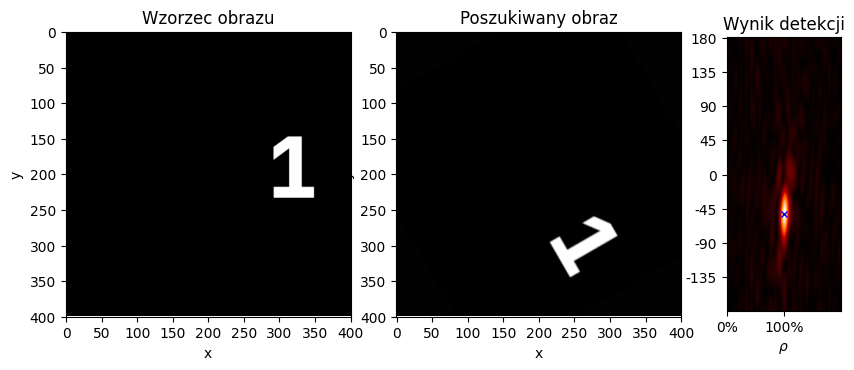

In [258]:
tpl_gen = SingleImageGenerator(TEMPLATE_PATH, logpolar=False)
test_gen = SingleImageGenerator(ROTATED_PATH, logpolar=False)
tr = FECTCorrTransformer(Config(offset_value_px=1), (360,150))
m = NaiveMatcher(thresh=THRESH)

tpl_ect = tr.transform(tpl_gen.generate())
m.initialize(tpl_ect)

test_ect = tr.transform(test_gen.generate())
ret = m.match(test_ect)

template = tpl_gen.generate()
image = test_gen.generate()
result = center(ret, lambda x: np.abs(np.fft.ifft2(x)))
display_detection(template, image, result)

print(template.shape)

### Detection - FECT scale

2024-05-17 21:56:27.607 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=1
2024-05-17 21:56:27.610 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping
2024-05-17 21:56:27.705 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=1
2024-05-17 21:56:27.708 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping


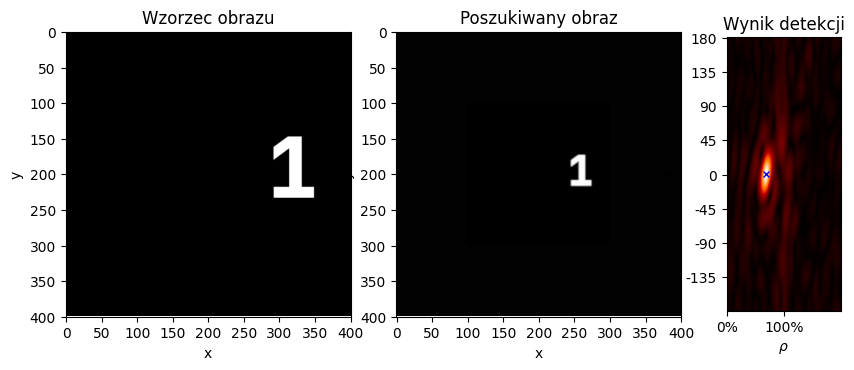

In [259]:
tpl_gen = SingleImageGenerator(TEMPLATE_PATH, logpolar=False)
test_gen = SingleImageGenerator(SCALED_PATH, logpolar=False)
tr = FECTCorrTransformer(Config(offset_value_px=1), (360,150))
m = NaiveMatcher(thresh=THRESH)

tpl_ect = tr.transform(tpl_gen.generate())
m.initialize(tpl_ect)

test_ect = tr.transform(test_gen.generate())
ret = m.match(test_ect)

template = tpl_gen.generate()
image = test_gen.generate()
result = center(ret, lambda x: np.abs(np.fft.ifft2(x)))
display_detection(template, image, result)


### Detection - FECT Shift

2024-05-17 21:56:28.098 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=1
2024-05-17 21:56:28.101 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping


2024-05-17 21:56:28.188 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=1
2024-05-17 21:56:28.191 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping


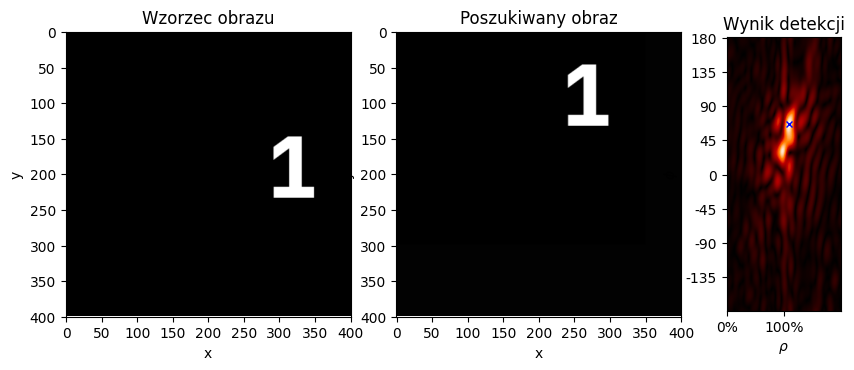

In [260]:
tpl_gen = SingleImageGenerator(TEMPLATE_PATH, logpolar=False)
test_gen = SingleImageGenerator(SHIFTED_PATH, logpolar=False)
tr = FECTCorrTransformer(Config(offset_value_px=1), (360,150))
m = NaiveMatcher(thresh=THRESH)

tpl_ect = tr.transform(tpl_gen.generate())
m.initialize(tpl_ect)

test_ect = tr.transform(test_gen.generate())
ret = m.match(test_ect)

template = tpl_gen.generate()
image = test_gen.generate()
result = center(ret, lambda x: np.abs(np.fft.ifft2(x)))
display_detection(template, image, result)
